In [7]:
import jsonlines
import os
import pandas as pd
import numpy as np

from statistics import mean
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import figure
import seaborn as sb
#pip install numba==0.57.0
import numba as nb
from numba import njit
from numba.core import types
from numba.typed import Dict

# A note on packages...

This analysis uses jsonlines to read history files, pandas & numpy for most data manipulation, matplotlib & seaborn for plotting, and numba to support fast nDCG calculations. It also makes use of the Python built-ins statistics and warnings. It has been tested with the following package versions (though it is not limited to these versions):
* jsonlines 3.1.0
* pandas 1.5.3
* numpy 1.24.3
* matplotlib 3.7.1
* seaborn 0.12.2
* numba 0.57.0

# Functions

In [2]:
# generate array for denom of ndcg calcs
rec_list = 10
base_logs = np.log2(np.arange(rec_list)+2)

@njit
def calculate_ndcg(histories: types.DictType(types.unicode_type, types.DictType(types.unicode_type, types.float64[:])), 
                  recommender: types.DictType(types.unicode_type, types.UniTuple(types.float64[:], 2)),
                  base_logs: types.float64[:]) -> types.float64[:]:
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores = np.empty(len(items), dtype=np.float64)
            #scores = []
            for item in items:
                idx_array = np.asarray(recommender[user][1] == item).nonzero()[0]
                if idx_array.size != 0:
                    idx = idx_array[0]
                    score = recommender[user][0][idx]
                else:
                    score = 0.0
                scores.append(score)
            #scores = np.asarray(scores)
            ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
            scores[scores > 0] = 1.0
            ideal_scores[ideal_scores > 0] = 1.0
            recdcg = np.sum(scores/base_logs)
            idealdcg = np.sum(ideal_scores/base_logs)
            if idealdcg == 0.0:
                ndcg = 0.0
            else:
                ndcg = recdcg/idealdcg
            i_count += 1
            all_ndcg += ndcg

        avg_of_ndcg.append(all_ndcg/i_count)
    return avg_of_ndcg

In [10]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicitly determined. Defaulting to integer...")
        var = int(var)
    return var

# given an item id return a list of its features as binary values
def get_item_features(item_features, item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [11]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicity determined. Defaulting to integer...")
        var = int(var)
    return var

# get recommendation score based on user and item ids
def lookupscore(user, item):
    score = recommender.loc[(recommender.User == typecast(recommender.User, user)) & (recommender.Item == typecast(recommender.Item, item))]
    if not score.empty:
        score = score['Score']
    else:
        score = 0.0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [4]:
### VISUALIZATION FUNCTIONS ###

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['COUNTRY_low_pfr'] == 0) & (alloc_df['loan_buck_5'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc

## Movies


In [17]:
# Base paths and experiment numbers
base_path = "../data/"
experiments = range(1, 11)

# Specify the base names for each experiment
base_names = [
    #"history_file_borda_least_movie",
    "history_file_borda_product_movie",
    #"history_file_broda_weighted_movie",
    # Add other base names here
]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

for base_name in base_names:
    for experiment_number in experiments:
        history_file_path = os.path.join(base_path, f"{base_name}_{experiment_number}.json")
        mechanism_name = f"{base_name.split('_')[-1].capitalize()} Experiment {experiment_number}"
        history_files.append(history_file_path)
        mechanisms.append(mechanism_name)

recs_file = "../data/ratings.csv"
items_file = "../data/items.csv"

In [18]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'women_writer_director') | (item_features['Feature'] == 'non-en')]

In [22]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [23]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(DictType[unicode_type,UniTuple(array(float64, 1d, A) x 2)]<iv=None>, int64, UniTuple(array(float64, 1d, C) x 2))
 
There are 16 candidate implementations:
  - Of which 14 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(DictType[unicode_type,UniTuple(array(float64, 1d, A) x 2)]<iv=None>, int64, UniTuple(array(float64, 1d, C) x 2))':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'impl_setitem': File: numba/typed/dictobject.py: Line 706.
    With argument(s): '(DictType[unicode_type,UniTuple(array(float64, 1d, A) x 2)]<iv=None>, int64, UniTuple(array(float64, 1d, C) x 2))':
   Rejected as the implementation raised a specific error:
     NumbaNotImplementedError: Failed in nopython mode pipeline (step: native lowering)
   Cannot cast int64 to unicode_type: i64 %"arg.key"
   During: lowering "castedkey = call $6load_global.0(key, $20load_deref.3, func=$6load_global.0, args=[Var(key, dictobject.py:714), Var($20load_deref.3, dictobject.py:715)], kws=(), vararg=None, varkwarg=None, target=None)" at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/typed/dictobject.py (715)
  raised from /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/core/base.py:701

During: typing of setitem at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/typed/typeddict.py (34)

File "../../../../../../Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/typed/typeddict.py", line 34:
def _setitem(d, key, value):
    d[key] = value
    ^


In [ ]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

# Synthetic Experiments
Below is the code used to analyze experiments using our synthetically-generated dataset. It calculates per-experiment nDCG and adjusted proportional fairness, we use these metrics to create our scatterplots. It also tracks SCRUF's internal representations of fairness which we utilize to create boxplots of the system's fairness scores.

In [ ]:
# specify paths to json outputs from scruf
BORDA_BASE = "/data/history_file_baseline_s1.json"
BORDA_LOT = "/data/history_file_product_alloc_borda_s1.json"
BORDA_WEIGHT = "/data/history_file_weighted_alloc_borda_s1.json"
BORDA_LEAST = "/data/history_file_least_fair_borda_s1.json"

COPELAND_BASE = "/data/history_file_baseline_s1.json"
COPELAND_LOT = "/data/history_file_product_alloc_copeland_s1.json"
COPELAND_WEIGHT = "/data/history_file_weighted_alloc_copeland_s1.json"
COPELAND_LEAST = "/data/history_file_least_fair_copeland_s1.json"

RP_BASE = "/data/history_file_baseline_s1.json"
RP_LOT = "/data/history_file_product_alloc_rankedpairs_s1.json"
RP_WEIGHT = "/data/history_file_weighted_alloc_ranked_pairs_s1.json"
RP_LEAST = "/data/history_file_least_fair_rankedpairs_s1.json"

WR_BASE = "/data/history_file_baseline_s1.json"
WR_LEAST = "/data/history_file_least_fair_rescore_s1.json"
WR_LOT = "/data/history_file_product_alloc_rescore_s1.json"
WR_WEIGHT = "/data/history_file_weighted_alloc_weighted_s1.json"

# paths to user|item|score files and item|feature files
recs_file = "/data/recs_s1.csv"
items_file = "/data/items_s1.csv"

In [ ]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])

In [ ]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE]


mechanisms = ['Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product','Weighted Rescore Least Fair','Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Baseline']

In [ ]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [ ]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

In [ ]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["0","1","2","3","4","5","6","7","8","9"]
protected_features = ["0", "1"]
fairness_targets = [0.25, 0.25]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [ ]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [ ]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [ ]:
# get fairness data to create boxplots
# create df w/ allocation/choice mechs and fairness scores over time
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["0","1"],var_name='Agent', value_name="Fairness")

In [ ]:
# store baseline means, then remove baseline
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "0"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "1"]["Fairness"].mean()
boxplots = experiments[experiments["Allocation Mech"] != "Baseline"]

In [ ]:
# rename for readability
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"

In [ ]:
# generate FacetGrid boxplots of internal representations of fairness scores 
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["0","1"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [ ]:
ndcg_fairness

In [ ]:
baseline_accuracy = ndcg_fairness.loc["Baseline"]
ndcg_fairness = ndcg_fairness.drop("Baseline")

In [ ]:
# rename for readability
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [ ]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [ ]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='synthetic_scatter.png')

# Kiva Experiments
Below is the code used to analyze experiments using the Kiva dataset. It mirrors the above analysis, with a few small changes to support the Kiva dataset.

In [ ]:
# specify paths to json outputs from scruf
BORDA_LOT = "/data/history_file_product_lottery_borda_kiva.json"
BORDA_WEIGHT = "/data/history_file_weighted_alloc_borda_kiva.json"
BORDA_LEAST = "/data/history_file_least_fair_borda_kiva.json"


COPELAND_LOT = "/data/history_file_product_lottery_copeland_kiva.json"
COPELAND_WEIGHT = "/data/history_file_weighted_alloc_copeland_kiva.json"
COPELAND_LEAST = "/data/history_file_least_fair_copeland_kiva.json"


RP_LOT = "/data/history_file_product_lottery_rankedpairs_kiva.json"
RP_WEIGHT = "/data/history_file_weighted_alloc_rankedpairs_kiva.json"
RP_LEAST = "/data/history_file_least_fair_rankedpairs_kiva.json"

WEIGHT_LEAST = "/data/history_file_least_fair_weighted_kiva.json"
WEIGHT_LOT = "/data/history_file_product_lottery_rescore_kiva.json"
WEIGHT_WEIGHT = "/data/history_file_weighted_alloc_weighted_kiva.json"

BASELINE = "/data/history_file_baseline_kiva.json"

# paths to user|item|score files and item|feature files
recs_file = "/data/kiva_recs.csv"
items_file = "/data/kiva_item.csv"

In [ ]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'COUNTRY_low_pfr') | (item_features['Feature'] == 'loan_buck_5')]

In [ ]:
dataset = item_features

# create a list of all feature combinations
all_features = ["COUNTRY_low_pfr", "loan_buck_5"]

# iterate over each item ID and feature combination
for item_id in range(1, 4998):
    for feature in all_features:
        # check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # if the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\

item_features = dataset

In [ ]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE]


mechanisms = ['Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product','Weighted Rescore Least Fair','Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Baseline']

In [ ]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [ ]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

In [ ]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["COUNTRY_low_pfr", "loan_buck_5"]
protected_features = ["COUNTRY_low_pfr", "loan_buck_5"]
fairness_targets = [0.20, 0.30]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [ ]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [ ]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [ ]:
# get fairness data to create boxplots
# create df w/ allocation/choice mechs and fairness scores over time
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["COUNTRY_low_pfr","loan_buck_5"],var_name='Agent', value_name="Fairness")

In [ ]:
# store baseline means, then remove baseline
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "COUNTRY_low_pfr"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "loan_buck_5"]["Fairness"].mean()
boxplots = experiments[experiments["Allocation Mech"] != "Baseline"]

In [ ]:
# rename for readability
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"
boxplots.replace("COUNTRY_low_pfr", "Country", inplace=True)
boxplots.replace("loan_buck_5", "Loan Size", inplace=True)

In [ ]:
# generate FacetGrid boxplots of internal representations of fairness scores 
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["Country","Loan Size"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [ ]:
ndcg_fairness

In [ ]:
baseline_accuracy = ndcg_fairness.loc["Baseline"]
ndcg_fairness = ndcg_fairness.drop("Baseline")

In [ ]:
# rename for readability
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [ ]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [ ]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12) # location for plots in paper, may need to change with other data
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='kiva_scatter.png')

In [4]:
import os

Movies Experiments

In [5]:
# Base paths and experiment numbers
base_path = "../data/"
experiments = range(1, 11)

# Specify the base names for each experiment
base_names = [
    #"history_file_borda_least_movie",
    "history_file_borda_product_movie",
    #"history_file_broda_weighted_movie",
    # Add other base names here
]

# Mapping of base names to lists and results dictionaries
#base_name_mapping = {
 #   "history_file_borda_weighted_movie": ('borda_w', 'results_borda_w'),
#}

# Generate file paths and mechanisms dynamically
history_files = []
mechanisms = []

for base_name in base_names:
    for experiment_number in experiments:
        history_file_path = os.path.join(base_path, f"{base_name}_{experiment_number}.json")
        mechanism_name = f"{base_name.split('_')[-1].capitalize()} Experiment {experiment_number}"
        history_files.append(history_file_path)
        mechanisms.append(mechanism_name)

recs_file = "../data/ratings.csv"
items_file = "../data/items.csv"

In [6]:
borda_1= []
borda_2 = []
borda_3= []
borda_4 = []
borda_5= []
borda_6 = []
borda_7= []
borda_8 = []
borda_9= []
borda_10 = []


list_names = [borda_1, borda_2, borda_3, borda_4, borda_5, borda_6, borda_7, borda_8, borda_9, borda_10]
readable_names = ['Borda 1', 'Borda 2', 'Borda 3', 'Borda 4', 'Borda 5', ' Borda 6', 'Borda 7', 'Borda 8', 'Borda 9','Borda 10']

In [7]:

results_borda_1= {}
results_borda_2 = {}
results_borda_3= {}
results_borda_4 = {}
results_borda_5= {}
results_borda_6 = {}
results_borda_7= {}
results_borda_8 = {}
results_borda_9= {}
results_borda_10 = {}



dict_names = [results_borda_1, results_borda_2,results_borda_3, results_borda_4, results_borda_5, results_borda_6, results_borda_7, results_borda_8, results_borda_9, results_borda_10]

In [8]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicity determined. Defaulting to integer...")
        var = int(var)
    return var

# get recommendation score based on user and item ids
def lookupscore(user, item):
    score = recommender.loc[(recommender.User == typecast(recommender.User, user)) & (recommender.Item == typecast(recommender.Item, item))]
    if not score.empty:
        score = score['Score']
    else:
        score = 0.0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [9]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'women_writer_director') | (item_features['Feature'] == 'non-en')]

In [10]:
# read history files
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [11]:
# process history files into dictionaries for statistics
for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 

In [15]:
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

In [16]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for history, name in zip(processed_histories, mechanisms):
    users = []
    ndcg_values = []
    for user, items in processed_histories[history]["Statistics"].items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == typecast(recommender.User, user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

AttributeError: 'list' object has no attribute 'items'

In [17]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=readable_names, columns=["NDCG"])
ndcg_table

,NDCG
Borda 1,0.021687
Borda 2,0.022174
Borda 3,0.022024
Borda 4,0.022497
Borda 5,0.022744
Borda 6,0.022812
Borda 7,0.022897
Borda 8,0.023024
Borda 9,0.023118
Borda 10,0.023036


In [18]:
# calculates proportional fairness for the representation of item features
num_features = 2
feature_names = ["women_writer_director","non-en"]
protected_features = ["women_writer_director","non-en"]
fairness_targets = [0.25, 0.25]

proportional_fairness = []
adj_fairness = []
feature_count= []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item)[0:1]):
                features[idx] = features[idx] + val
    
    feature_count.append(features[0])
    proportional = [(x)/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            if name in "non-en":
                print(proportional[idx])
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [19]:
i = item_features[item_features['Feature']=='non-en']
i = i[i['BV'] == 1]
i

,Item,Feature,BV
3,902,non-en,1
9,4482,non-en,1
10,880,non-en,1
11,649,non-en,1
20,110,non-en,1
...,...,...,...
1544,80831,non-en,1
1545,64197,non-en,1
1546,98604,non-en,1
1547,5589,non-en,1


In [20]:
prop_fairness = pd.DataFrame(adj_fairness)

In [21]:
prop_fairness

,0,1
0,1.344662,0.0
1,1.346841,0.0
2,1.260480,0.0
3,1.098995,0.0
4,0.990976,0.0
5,0.917691,0.0
6,0.869334,0.0
7,0.832147,0.0
8,0.798706,0.0
9,0.770713,0.0


In [22]:
ndcg_table.reset_index(inplace=True)
ndcg_table = ndcg_table.rename(columns = {'index':'Type'})

In [23]:
ndcg_fairness = prop_fairness.merge(ndcg_table, left_index = True, right_index = True)
ndcg_fairness = ndcg_fairness.rename(columns = {0:'Average Fairness Score'})

In [24]:
ndcg_fairness

,Average Fairness Score,1,Type,NDCG
0,1.344662,0.0,Borda 1,0.021687
1,1.346841,0.0,Borda 2,0.022174
2,1.260480,0.0,Borda 3,0.022024
3,1.098995,0.0,Borda 4,0.022497
4,0.990976,0.0,Borda 5,0.022744
5,0.917691,0.0,Borda 6,0.022812
6,0.869334,0.0,Borda 7,0.022897
7,0.832147,0.0,Borda 8,0.023024
8,0.798706,0.0,Borda 9,0.023118
9,0.770713,0.0,Borda 10,0.023036


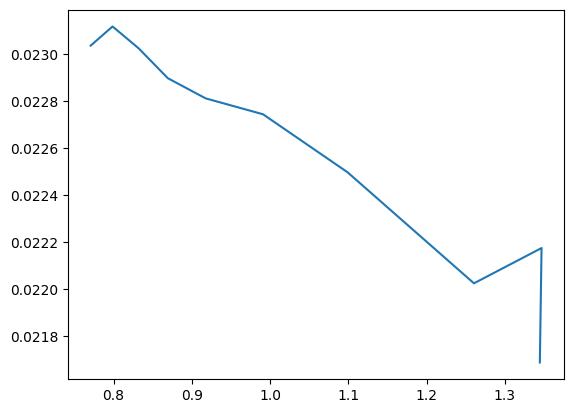

In [25]:
# Extract the date and close price columns
Gender_fairness = ndcg_fairness['Average Fairness Score']
ndcg = ndcg_fairness['NDCG']

# Create a line plot
plt.plot(Gender_fairness, ndcg)

In [14]:
dataset = item_features

# create a list of all feature combinations
all_features = ["women_writer_director", "non-en"]

# iterate over each item ID and feature combination
for item_id in range(1,1550):
    for feature in all_features:
        # check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # if the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\

item_features = dataset

/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_58804/2601213558.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_58804/2601213558.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_58804/2601213558.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/1t/44v3s5n97h1drxtq1zb_gdlm0000gq/T/ipykernel_58804/26

In [15]:
# read in data from history files & store in dict
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [35]:
# convert history + recommender info to typed dicts for numba
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

#light_recommender = Dict.empty(
 #   key_type=types.unicode_type,
  #  value_type=types.UniTuple(types.float64[:], 2),
#)
count=0
light_recommender = {}
for user in recommender["User"].unique():

    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    #print(type(light_recommender))
    count+=len(scores)
    light_recommender[user] = (scores, items)
print(count)

559069


In [52]:
import numpy as np
from numba import njit

def calculate_ndcg(histories, recommender, base_logs):
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores_list = []
            for item in items:
                # Check if the user is in the recommender dictionary
                if user in recommender and len(recommender[user][1]) > 0:
                    idx_array = np.where(recommender[user][1] == item)[0]
                    if idx_array.size != 0:
                        idx = idx_array[0]
                        score = recommender[user][0][idx]
                    else:
                        score = 0.0
                else:
                    score = 0.0
                scores_list.append(score)

            scores = np.array(scores_list)  # Convert the list back to a NumPy array
            # Check if the user is in the recommender dictionary
            if user in recommender and len(recommender[user][0]) > 0:
                ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
                scores[scores > 0] = 1.0
                ideal_scores[ideal_scores > 0] = 1.0
                recdcg = np.sum(scores / base_logs)
                idealdcg = np.sum(ideal_scores / base_logs)
                if idealdcg == 0.0:
                    ndcg = 0
                else:
                    ndcg = recdcg / idealdcg
                i_count += 1
                all_ndcg += ndcg
        if i_count > 0:
            avg_of_ndcg.append(all_ndcg / i_count)
    return avg_of_ndcg


# Usage example:
# avg_ndcg = calculate_ndcg(histories_dict, recommender_dict, base_logs_array)



In [53]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [54]:
avg_of_ndcg

[]

In [14]:
from numba import typed
# Create a Numba-typed dictionary
num_keys = len(light_recommender)
numba_dict = typed.Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 559069),
    #size=num_keys
)
# Populate the Numba-typed dictionary with items from the regular dictionary
for key, value in light_recommender.items():
    numba_dict[key] = value

In [36]:
type(numba_dict)

dict

In [ ]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

In [ ]:
# calculates adj proportional fairness for the representation of item features
num_features = 10
feature_names = ["COUNTRY_low_pfr", "loan_buck_5"]
protected_features = ["COUNTRY_low_pfr", "loan_buck_5"]
fairness_targets = [0.20, 0.30]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item_features, item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [17]:
#pip install numba==0.57.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.6 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for llvmlite<0.41,>=0.40.0dev0 from https://files.pythonhosted.org/packages/2b/da/9de67270696d43ab28eba38c9a248f646e6b9a3fb2c7115504a2a986f55f/llvmlite-0.40.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 9.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.0
    Uninstalling llvmlite-0.41.0:
      Successfully uninstalled llvmlite-0.41.0
  Attempting uninstall: numba
    Found existing installation: numba 0.58.0
    Uninstalling numba-0.58.0:
      Successfully uninstalled numba-0.58.0

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
